Download colab_utils and import



<a href="https://colab.research.google.com/github/beangoben/gnn_workshop_riiaa/blob/master/Prediccion de Nodos con Arxiv MAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
!wget https://raw.githubusercontent.com/beangoben/gnn_workshop_riiaa/master/colab_utils.py -O colab_utils.py
!rm -rf sample_data
github_repo = 'https://github.com/beangoben/gnn_workshop_riiaa'
import colab_utils
colab_utils.clone_repo(github_repo)

--2021-08-25 16:42:14--  https://raw.githubusercontent.com/beangoben/gnn_workshop_riiaa/master/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7173 (7.0K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   7.00K  --.-KB/s    in 0s      

2021-08-25 16:42:14 (54.6 MB/s) - ‘colab_utils.py’ saved [7173/7173]

CMD: git clone --recursive https://github.com/beangoben/gnn_workshop_riiaa


Clone github repo, install stuff

In [34]:
if colab_utils.is_running_colab():
    colab_utils.pip_install(['umap-learn', 'dm-sonnet', 'graph_nets', 'rdkit-pypi', 'ml-collections', 'tensorflow-addons'])

CMD: pip install  umap-learn
CMD: pip install  dm-sonnet
CMD: pip install  graph_nets
CMD: pip install  rdkit-pypi
CMD: pip install  ml-collections
CMD: pip install  tensorflow-addons


# Import modules


In [35]:
import os
from collections import OrderedDict, defaultdict

import tqdm.auto as tqdm
import colab_utils 

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import networkx as nx

import sklearn
import umap
import tensorflow as tf
import tensorflow_addons as tfa

import sonnet as snt
import graph_nets as gn

import rdkit
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
from rdkit.Chem import AllChem, Draw
import rdkit.Chem.rdFingerprintGenerator as rdFP
from rdkit.Chem.Draw import IPythonConsole

colab_utils.print_module_versions([umap, tf, tfa, snt, nx, rdkit])
print(f'Tiene GPU? {tf.config.list_physical_devices("gpu")}')
colab_utils.matplotlib_settings()

umap      : 0.5.1
tensorflow: 2.6.0
tensorflow_addons: 0.14.0
sonnet    : 2.0.0
networkx  : 2.6.2
rdkit     : 2021.03.4
Tiene GPU? []


## Lodear dataset (grafos moleculares)

In [5]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2021-08-25 16:43:58--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.01s   

2021-08-25 16:43:58 (6.76 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [6]:
df = pd.read_csv('delaney-processed.csv')
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
print(df.shape)
print(df.columns)
df.head()

(1128, 11)
Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles', 'mol'],
      dtype='object')


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7fa3999a4080>
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7fa3999c3f30>
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x7fa3999c3f80>
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x7fa3999c3ee0>
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x7fa3999c3e90>


# Visualizar los grafos

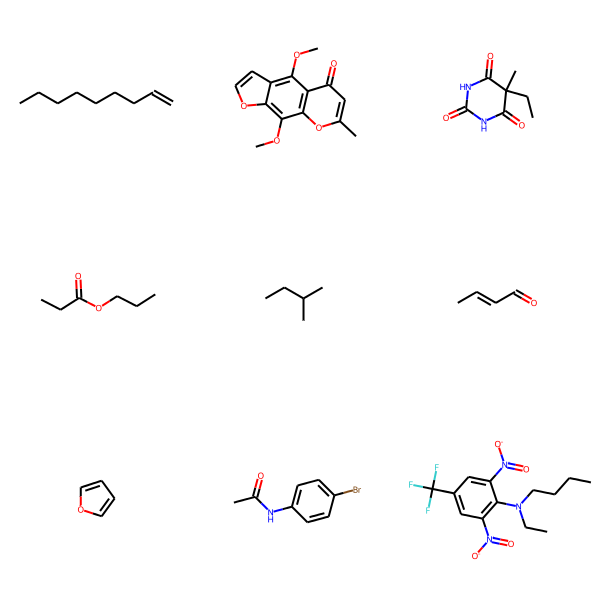

In [12]:
mols = df['mol'].sample(n=9).tolist()
Draw.MolsToGridImage(mols)

## Construir train-test split

In [25]:
indices = np.array(df.index)
smi = np.array(df['smiles'].tolist())
mols = np.array(df['mol'].tolist())
train_index, test_index = sklearn.model_selection.train_test_split(indices, test_size=.20)
mols_train, mols_test = mols[train_index], mols[test_index]
smi_train, smi_test = smi[train_index], smi[test_index]
print(len(train_index),len(test_index))

902 226


## Propiedad de interes

In [14]:
target = "measured log solubility in mols per litre"
y_true = df[target].values.reshape(-1,1).astype(np.float32)
y_train = y_true[train_index]
y_test = y_true[test_index]
print(y_train.shape, y_test.shape)

(902, 1) (226, 1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


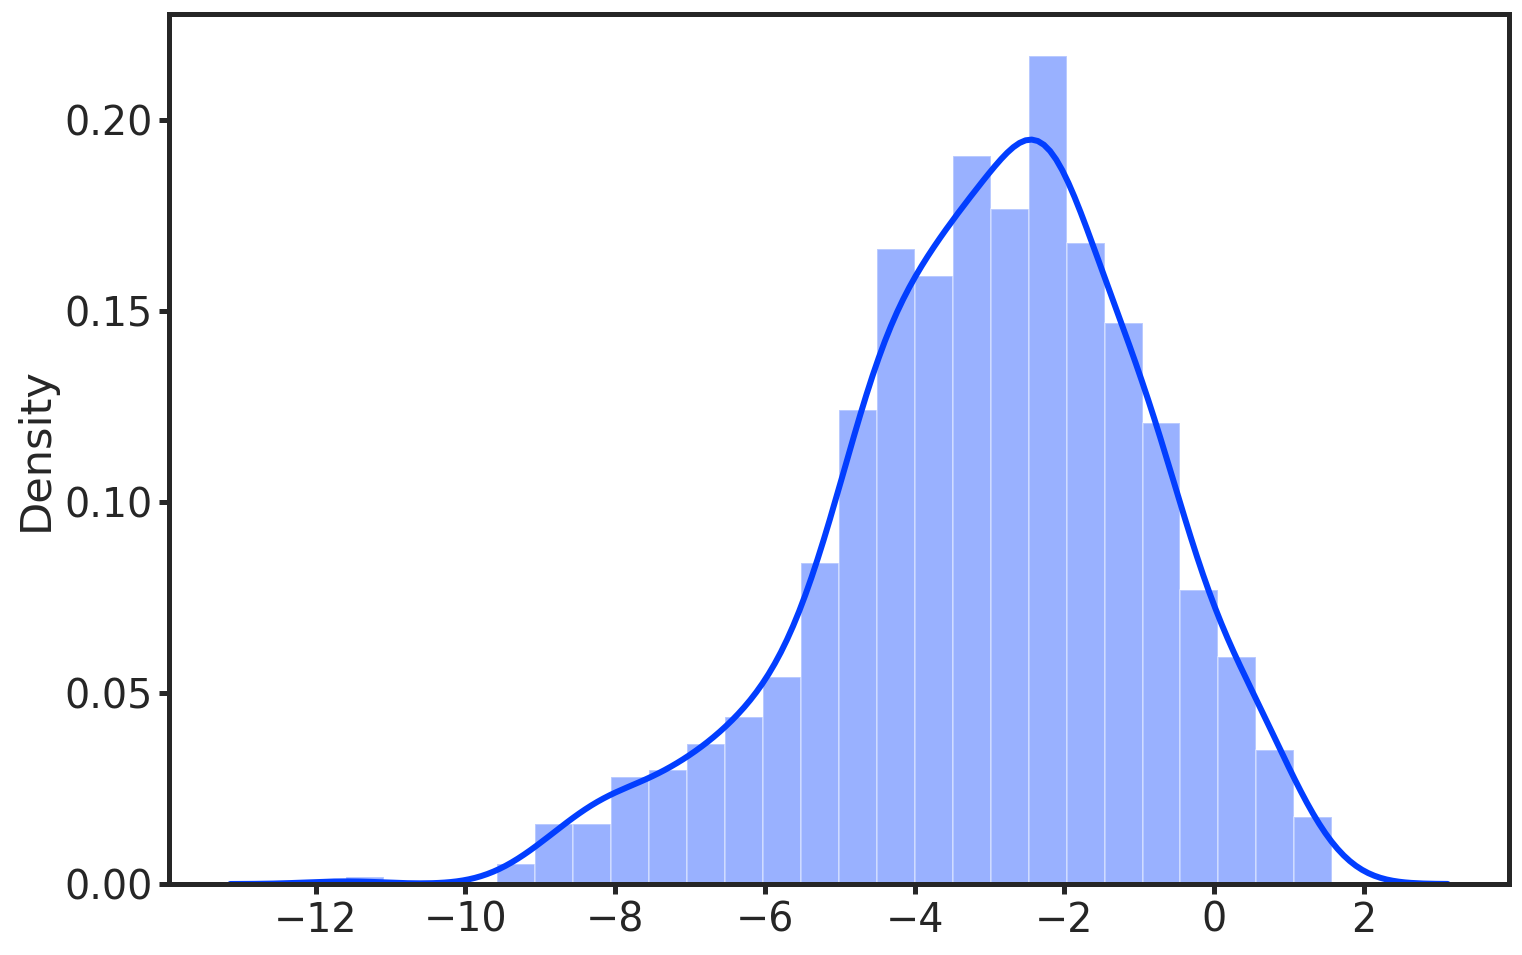

In [15]:
sns.distplot(y_true)

## Un baseline con modelos lineales

In [16]:
fps =  [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in mols]
fps = np.vstack(np.array(fps)).astype(np.float32)
fps_train, fps_test = fps[train_index], fps[test_index]
fps.shape

(1128, 2048)

In [17]:
model = snt.Sequential([ snt.Linear(1024),tf.nn.relu, snt.Linear(1)])
model(fps_train)

<tf.Tensor: shape=(902, 1), dtype=float32, numpy=
array([[ 3.13544646e-03],
       [-5.15672453e-02],
       [-3.74482833e-02],
       [-6.23492450e-02],
       [ 3.28345038e-03],
       [-8.17152560e-02],
       [ 2.63636094e-02],
       [-6.40862733e-02],
       [ 4.59886491e-02],
       [-1.46567188e-02],
       [-5.81633896e-02],
       [-1.07492968e-01],
       [ 1.27680413e-03],
       [ 3.42747085e-02],
       [-2.49761790e-02],
       [-8.06079358e-02],
       [-1.01327617e-02],
       [-5.50615191e-02],
       [-7.18547404e-02],
       [-4.25458811e-02],
       [-2.82791331e-02],
       [-1.81981176e-02],
       [ 1.70045849e-02],
       [-6.00747727e-02],
       [-2.68428810e-02],
       [-1.81054510e-02],
       [-5.60590141e-02],
       [ 2.40914747e-02],
       [ 9.98533070e-02],
       [-1.49965838e-01],
       [-6.70105591e-03],
       [-2.56620646e-02],
       [-1.31305456e-02],
       [-3.50705832e-02],
       [-4.23403233e-02],
       [-1.93659365e-01],
       [-6.007

In [53]:
def cast_as_np(a):
    return a.numpy() if isinstance(a, tf.Tensor) else a
    
def calc_stats(y_true, y_pred, prefix):
    """Conseguir estadisticas"""
    return {f'{prefix}_loss':loss_fn(y_true, y_pred).numpy(), 
            f'{prefix}_MAE':metric(y_true, y_pred).numpy(),
            f'{prefix}_R2':tfa.metrics.RSquare()(cast_as_np(y_true).ravel(), cast_as_np(y_pred).ravel()).numpy()}

In [55]:
NUM_ITER = 100
loss_fn = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam(3e-4)

pbar = tqdm.tqdm(range(NUM_ITER))
stats = []

for i in pbar:
    with tf.GradientTape() as tape:
      y_pred = model(fps_train) # pred
      loss = loss_fn(y_train, y_pred) 
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # Train statistics.
    y_pred =  model(fps_train)
    stat = calc_stats(y_train, y_pred , 'train')
    # Test statistics.
    y_pred =  model(fps_test)
    stat.update(calc_stats(y_test, y_pred, 'test'))
    stats.append(stat)
    # Update progress bar.
    pbar.set_postfix(stats[-1])
pd.DataFrame(stats)

  0%|          | 0/100 [00:00<?, ?it/s]

,train_loss,train_MAE,train_R2,test_loss,test_MAE,test_R2
0,0.091535,0.774950,0.979216,1.688292,0.775077,0.610872
1,0.100735,0.773561,0.977128,1.685467,0.773687,0.611524
2,0.085533,0.772024,0.980579,1.680852,0.772152,0.612587
3,0.082219,0.770425,0.981332,1.694653,0.770557,0.609406
4,0.090434,0.768971,0.979466,1.714871,0.769108,0.604746
...,...,...,...,...,...,...
95,0.079329,0.653810,0.981988,1.694879,0.653970,0.609354
96,0.079314,0.652802,0.981991,1.694839,0.652961,0.609363
97,0.079299,0.651798,0.981995,1.694816,0.651958,0.609369
98,0.079285,0.650799,0.981998,1.694905,0.650959,0.609348


## Mol a grafo

In [23]:
from typing import Any, Dict, List, Text, Tuple

import graph_nets
import more_itertools
import numpy as np
import rdkit.Chem
import sonnet as snt
import tensorflow as tf
from rdkit import Chem



# Typing alias.
GraphsTuple = graph_nets.graphs.GraphsTuple

ATOM_TYPES = ['S', 'Si', 'F', 'O',
                      'C', 'I', 'P', 'Cl', 'Br', 'N', 'Unknown']
NULL_MOLECULE_SMILES = '[*]~[*]'
BOND_TYPES = ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'UNSPECIFIED']


def smiles_to_mol(smiles, infer_hydrogens=False):
    """Basic smiles to RDkit mol."""
    mol = Chem.MolFromSmiles(smiles)
    assert mol is not None, 'Could not parse smiles {}'.format(smiles)
    if infer_hydrogens:
        mol = Chem.AddHs(mol)
    return mol


def _onehot_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class MolTensorizer(object):
    """MolTensorizer: Convert data into molecular tensors.
    Utility object to preprocess a dataset, compute feature values, learn
    their range and convert molecules into tensors.
    """

    def __init__(self, preprocess_fn=smiles_to_mol):
        self.preprocess_fn = preprocess_fn

    def get_null_vectors(self) -> Tuple[np.ndarray, np.ndarray]:
        """Gets atom and bond featurized vectors for unspecified molecule."""
        null_mol = smiles_to_mol(NULL_MOLECULE_SMILES)
        null_atom = null_mol.GetAtomWithIdx(0)
        null_bond = null_mol.GetBondWithIdx(0)
        null_atomvec = self.atom_features(null_atom)
        null_bondvec = self.bond_features(null_bond)
        return null_atomvec, null_bondvec

    def atom_features(self, atom):
        return np.array(_onehot_encoding_unk(atom.GetSymbol(), ATOM_TYPES))

    def bond_features(self, bond):
        return np.array(_onehot_encoding_unk(
            str(bond.GetBondType()), BOND_TYPES))

    def mol_to_data_dict(self, mol: Chem.Mol) -> Dict[Text, np.ndarray]:
        """Gets data dict from a single mol."""
        nodes = np.array([self.atom_features(atom) for atom in mol.GetAtoms()])
        edges = np.zeros((mol.GetNumBonds() * 2, len(BOND_TYPES)))
        senders = []
        receivers = []
        for index, bond in enumerate(mol.GetBonds()):
            id1 = bond.GetBeginAtom().GetIdx()
            id2 = bond.GetEndAtom().GetIdx()
            bond_arr = self.bond_features(bond)
            edges[index * 2, :] = bond_arr
            edges[index * 2 + 1, :] = bond_arr
            senders.extend([id1, id2])
            receivers.extend([id2, id1])
        data_dict = {
            'nodes': nodes.astype(np.float32),
            'edges': edges.astype(np.float32),
            'globals': np.array([0.], dtype=np.float32),
            'senders': np.array(senders, np.int32),
            'receivers': np.array(receivers, np.int32)
        }
        return data_dict

    def transform_data_dict(self,
                            data: List[Any]) -> List[Dict[Text, np.ndarray]]:
        """Transform to data dicts, useful with graph_nets library."""
        mol_list = [self.preprocess_fn(item) for item in data]
        data_dicts = list(map(self.mol_to_data_dict, mol_list))
        return data_dicts


def smiles_to_graphs_tuple(
        smiles_list: List[Text],
        tensorizer: MolTensorizer) -> GraphsTuple:
    """Converts smiles to graphs tuple."""
    graph_list = tensorizer.transform_data_dict(smiles_list)
    return graph_nets.utils_tf.data_dicts_to_graphs_tuple(graph_list)

In [26]:
tensorizer = MolTensorizer()
x_train = smiles_to_graphs_tuple(smi_train, tensorizer)
x_test = smiles_to_graphs_tuple(smi_test, tensorizer)

In [27]:
x_train

GraphsTuple(nodes=<tf.Tensor: shape=(11981, 11), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, edges=<tf.Tensor: shape=(24638, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>, receivers=<tf.Tensor: shape=(24638,), dtype=int32, numpy=array([    1,     0,     2, ..., 11980, 11974, 11979], dtype=int32)>, senders=<tf.Tensor: shape=(24638,), dtype=int32, numpy=array([    0,     1,     1, ..., 11967, 11979, 11974], dtype=int32)>, globals=<tf.Tensor: shape=(902, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [

# Armar un GNN para regression

In [28]:
def get_num_parameters(model: snt.Module, trainable: bool = True) -> int:
  """Numero de parametros."""
  variables = model.trainable_variables if trainable else model.variables
  return int(np.sum([np.prod(v.shape) for v in variables]))


def print_model(model: snt.Module):
  """Sumario de un modelo."""
  print(f'{model.__class__.__name__} : {model.name}\n')
  print(snt.format_variables(model.variables))
  n_params = get_num_parameters(model, False)
  trainable_params = get_num_parameters(model, True)
  print(f'\nParams: {trainable_params} trainable out of {n_params}')

## Bloque de transformacion

In [29]:
def make_mlp_model(latent_size=32, n_layers=2, add_head=0):
    """Crea un MLP luego pasando por un LayerNorm y opcionalmente una capa lineal."""
    layers = [
        snt.nets.MLP([latent_size] * n_layers, activate_final=True),
        snt.LayerNorm(axis=-1, create_offset=True, create_scale=True)]
    if add_head > 0:
        layers.append(snt.Linear(add_head))
    return snt.Sequential(layers)
    
bloque = make_mlp_model(32, 2, 0)
bloque(x_train.nodes)
print_model(bloque)

Sequential : sequential

| Variable          | Spec       | Trainable   | Device   |
|-------------------+------------+-------------+----------|
| layer_norm/offset | f32[32]    | True        | GPU      |
| layer_norm/scale  | f32[32]    | True        | GPU      |
| mlp/linear_0/w    | f32[11,32] | True        | GPU      |
| mlp/linear_0/b    | f32[32]    | True        | GPU      |
| mlp/linear_1/w    | f32[32,32] | True        | GPU      |
| mlp/linear_1/b    | f32[32]    | True        | GPU      |

Params: 1504 trainable out of 1504


## GNN: GraphNets

In [56]:
cabeza = gn.modules.GraphIndependent(global_model_fn=lambda: snt.Linear(1))

gnn_layers = [gn.modules.GraphNetwork(
    edge_model_fn=lambda: make_mlp_model(32, 2),
    node_model_fn=lambda: make_mlp_model(32, 2),
    global_model_fn=lambda: make_mlp_model(32, 2)) for i in range(3)]

gnn = snt.Sequential( gnn_layers + [cabeza])
out = gnn(x_train)
print(out)
print_model(gnn)

GraphsTuple(nodes=<tf.Tensor: shape=(11981, 32), dtype=float32, numpy=
array([[ 1.2987901 , -0.84833395, -0.84833395, ...,  0.9732441 ,
        -0.84833395,  1.0380185 ],
       [-0.72123533, -0.72123533, -0.72123533, ..., -0.5919878 ,
        -0.72123533,  0.35382885],
       [-0.36032453, -0.7055062 , -0.7055062 , ..., -0.3863008 ,
        -0.7055062 ,  1.7659737 ],
       ...,
       [ 0.4281876 , -0.78068316, -0.78068316, ...,  0.45106745,
        -0.78068316,  1.2394987 ],
       [ 0.20758039, -0.952769  ,  0.10245842, ..., -0.952769  ,
        -0.952769  ,  0.8047808 ],
       [-0.2531361 , -0.82758695, -0.40412962, ..., -0.82758695,
        -0.82758695, -0.36047843]], dtype=float32)>, edges=<tf.Tensor: shape=(24638, 32), dtype=float32, numpy=
array([[ 0.22444957, -0.28271446, -0.66302305, ..., -0.66302305,
         2.5973916 , -0.31282714],
       [ 0.99123865, -0.7883902 , -0.7883902 , ..., -0.7883902 ,
         3.5976915 ,  1.5986907 ],
       [-0.3661084 , -0.09849343, -0.557

In [57]:
NUM_ITER = 100
optimizer = tf.optimizers.Adam(3e-3)
metric = tf.keras.metrics.MeanAbsoluteError()
loss_fn = tf.keras.losses.MeanSquaredError()

In [58]:
@tf.function(experimental_relax_shapes=True)
def forward_pass(x):
    """Prediccion."""
    out_x = gnn(x)
    return out_x.globals

In [59]:
pbar = tqdm.tqdm(range(NUM_ITER))
stats = []

for i in pbar:
    with tf.GradientTape() as tape:
      y_pred = forward_pass(x_train)
      loss = loss_fn(y_train, y_pred)
    grads = tape.gradient(loss, gnn.trainable_variables)
    optimizer.apply_gradients((grad, var) 
    for (grad, var) in zip(grads, gnn.trainable_variables) 
    if grad is not None)
    # Train statistics.
    y_pred =  gnn(x_train).globals
    stat = calc_stats(y_train, y_pred , 'train')
    # Test statistics.
    y_pred =  gnn(x_test).globals
    stat.update(calc_stats(y_test, y_pred, 'test'))
    stats.append(stat)
    # Update progress bar.
    pbar.set_postfix(stats[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
train_df = pd.DataFrame(stats)
train_df

,train_loss,train_MAE,test_loss,test_MAE
0,8.700858,2.351007,9.825430,2.381045
1,5.897854,2.161326,6.641030,2.139552
2,4.934921,2.020156,5.460413,2.002328
3,4.483770,1.930652,4.826425,1.917198
4,4.356870,1.874330,4.537729,1.865207
...,...,...,...,...
95,4.356869,1.668134,4.538458,1.668089
96,4.356868,1.668021,4.538229,1.667977
97,4.356868,1.667910,4.538179,1.667867
98,4.356868,1.667802,4.538371,1.667759


No handles with labels found to put in legend.


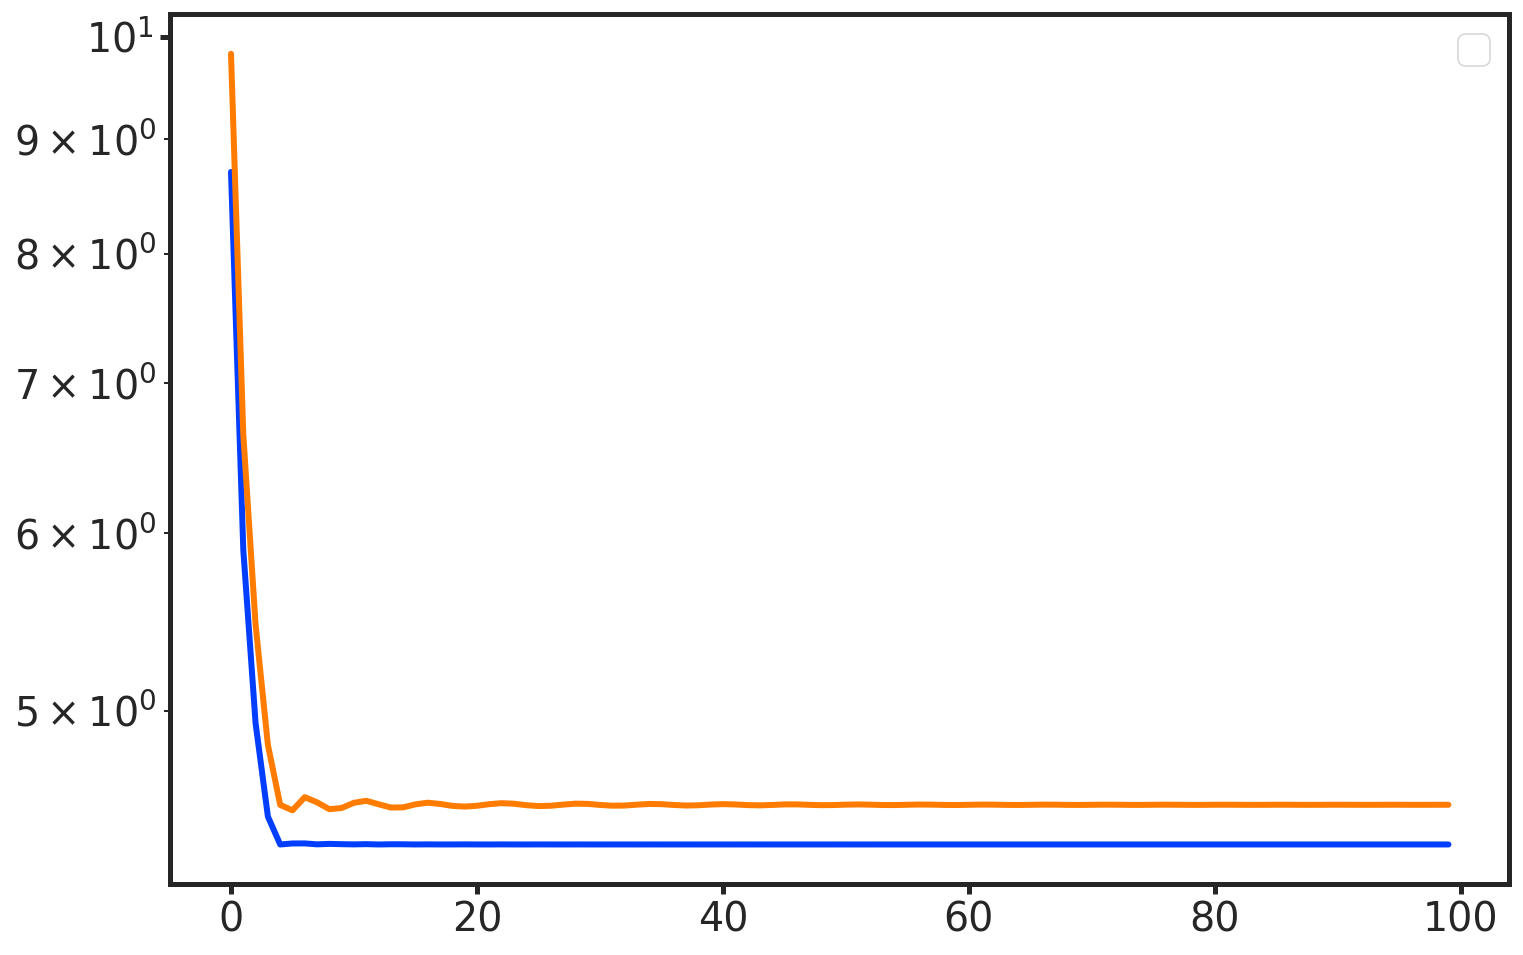

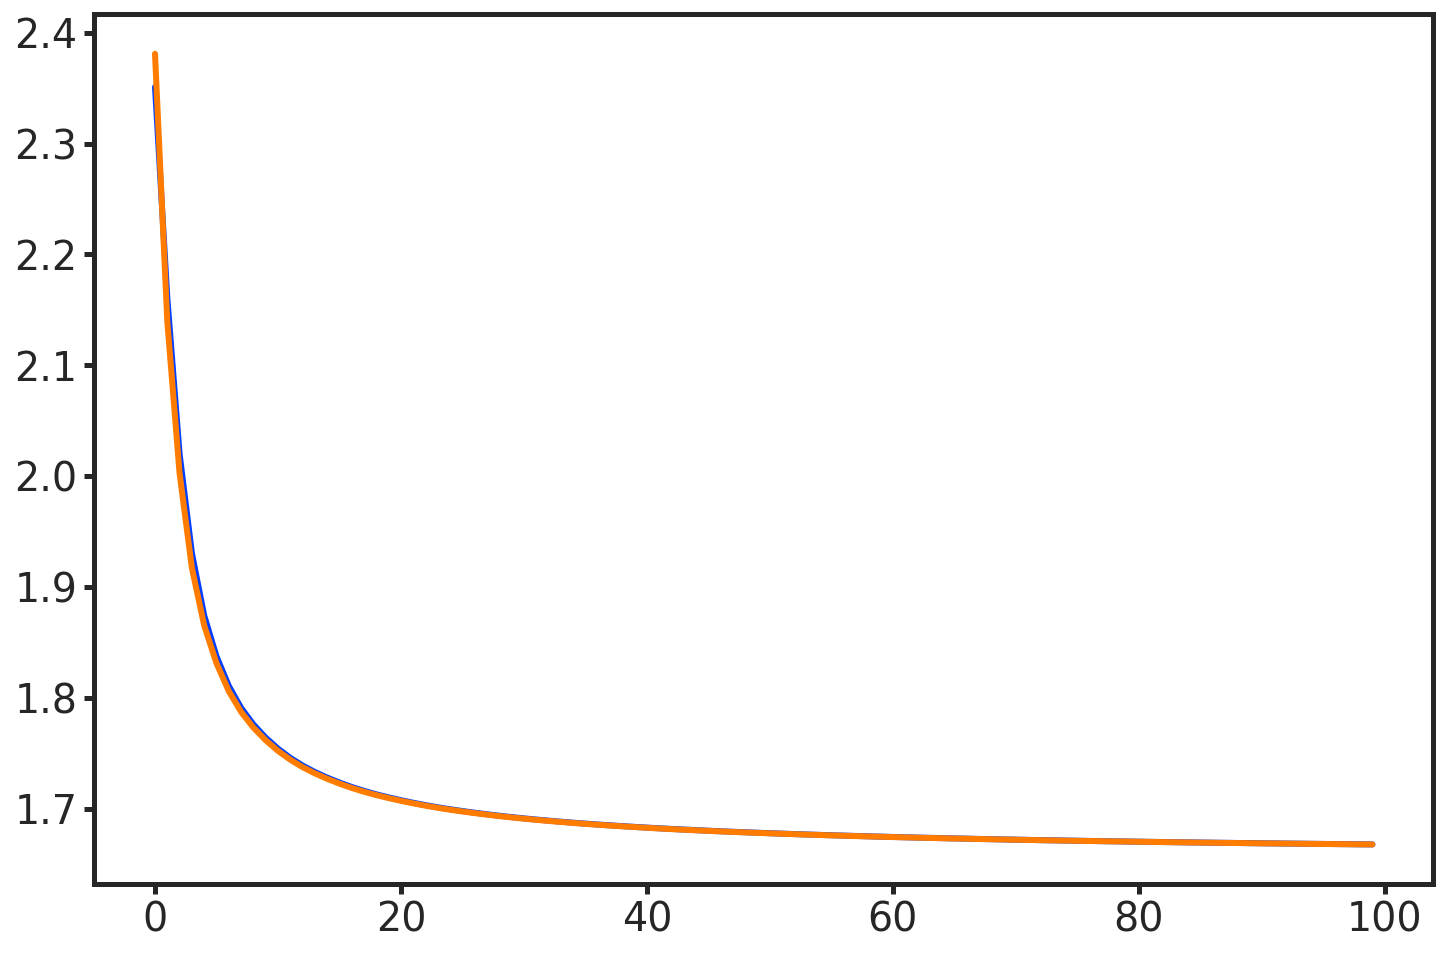

In [ ]:
for key in ['train_loss','test_loss']:
    plt.plot(train_df[key])
plt.yscale('log')
plt.legend()
plt.show()

for key in ['train_MAE','test_MAE']:
    plt.plot(train_df[key])
plt.show()